# Custom network from a streets dataset

Use `geopandas` to open a street network file and convert it to a `networkx` graph.

If you have a street network file in a GeoPackage, shapefile, or similar format, then you can load this file and convert it to a `networkx` graph.


In [3]:
import geopandas as gpd
from cityseer.tools import io, plot

Use `geopandas` to load the street network file. Check that your file path is correct!


In [4]:
streets_gpd = gpd.read_file("data/madrid_streets/street_network.gpkg")
streets_gpd.head()

,GEODB_OID,CDID,CDMUNI,CDVIAL,CDTVIA,DSPART,DSVIAL,DSVIAL_25,DSVIAL_NOR,CDVIAL_INE,TIPOLOGIA,GEOMETRY1_,geometry
0,2116085.0,2116085.0,049,049A0246,Avda,de,San Pablo,San Pablo,SAN PABLO,00624,35.0,1424.530768,"MULTILINESTRING ((454855.882 4476818.629, 4548..."
1,2116085.0,2116085.0,049,049A0246,Avda,de,San Pablo,San Pablo,SAN PABLO,00624,35.0,1424.530768,"MULTILINESTRING ((454839.501 4476885.272, 4548..."
2,2116085.0,2116085.0,049,049A0246,Avda,de,San Pablo,San Pablo,SAN PABLO,00624,35.0,1424.530768,"MULTILINESTRING ((454833.577 4476910.504, 4548..."
3,2116085.0,2116085.0,049,049A0246,Avda,de,San Pablo,San Pablo,SAN PABLO,00624,35.0,1424.530768,"MULTILINESTRING ((454823.07 4476952.149, 45482..."
4,2116085.0,2116085.0,049,049A0246,Avda,de,San Pablo,San Pablo,SAN PABLO,00624,35.0,1424.530768,"MULTILINESTRING ((454817.822 4476974.014, 4548..."


Take note of you data CRS.


In [5]:
epsg_code = streets_gpd.crs.to_epsg()
print(epsg_code)
print(streets_gpd.crs.is_projected)

25830
True


If your street network is not in a projected CRS, it is recommended to convert your dataset to a locally projected coordinate system. This can be done with the built-in `to_crs` method in `geopandas`. The EPSG code for the UTM zone can be found at [epsg.io](https://epsg.io/).

Alternatively, you can project the graph after creation.


In [6]:
# shown as example - unnecessary step for current dataset
streets_gpd = streets_gpd.to_crs(epsg=25830)
print(epsg_code)
print(streets_gpd.crs.is_projected)

25830
True


Take note of the geometry type.


In [7]:
streets_gpd.geometry.type.unique()

array(['MultiLineString'], dtype=object)

If your data consists of `MultiLineString` geometries, then these should first be converted to unnested `LineString` geometries.


In [8]:
streets_gpd = streets_gpd.explode(ignore_index=True)
streets_gpd.geometry.type.unique()

array(['LineString'], dtype=object)

Use the [`nx_from_generic_geopandas`](https://cityseer.benchmarkurbanism.com/tools/io#nx-from-generic-geopandas) function to convert the `geopandas` LineStrings dataset to a `networkx` graph. This function will automatically create nodes and edges from the LineStrings in the dataset.

The function expects that all features are `LineString` geometries, where the geometries represent individual street segments that meet at intersections. Street segments which share endpoints will be connected by a node in the graph.


In [9]:
G = io.nx_from_generic_geopandas(streets_gpd)
print(G)

100%|██████████| 47155/47155 [00:06<00:00, 7684.49it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|██████████| 47129/47129 [00:00<00:00, 280225.96it/s]


MultiGraph with 31280 nodes and 47129 edges


INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 47129/47129 [00:00<00:00, 61490.78it/s]


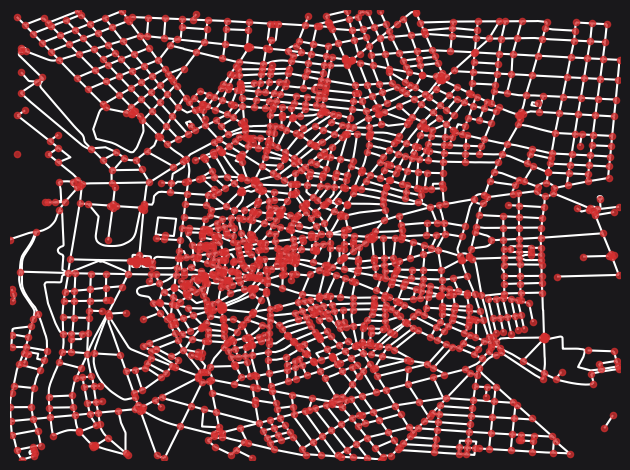

In [ ]:
plot.plot_nx(
    G,
    plot_geoms=True,
    x_lim=(438500, 438500 + 3500),
    y_lim=(4472500, 4472500 + 3500),
)

If your data is not in a projected CRS (and if you did not already reproject the `GeoDataFrame` before creating the graph), then reproject your `networkx` graph to a locally projected coordinate system before doing further analysis.

If the data is currently in geographic longitudes and latitudes (WGS84 / 4326) then the [`nx_wgs_to_utm`](https://cityseer.benchmarkurbanism.com/tools/io#nx-wgs-to-utm) function can be used to convert it to the local UTM projection. Alternatively, the [nx_epsg_conversion](https://cityseer.benchmarkurbanism.com/tools/io#nx-epsg-conversion) function can be used to specify input and output CRS.


In [11]:
# shown as an example - unnecessary step for current dataset
G_utm = io.nx_epsg_conversion(G, to_crs_code=32630)
print(G_utm)

INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 31280/31280 [00:00<00:00, 1153945.46it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 47129/47129 [00:03<00:00, 15486.95it/s]

MultiGraph with 31280 nodes and 47129 edges
